# Problem Statement
Predict if the engine will fail within a particular cycle given its history of cycles and sensory data?

### Objective

Aircrafts are very sensitive to the faults in their engines. Owing to this it becomes very crucial to keep them in a good stead for the safety of the passengers. While the aircrafts are very expensive, their maintenance is also quite costly. Hence at the same time, we don’t want to overdo the maintenance. Moreover if we don’t detect the fault soon, the engines might reach a phase where the maintenance cost increases or even a replacement is mandatory. Now think if we could predict when the engine's failures are going to occur so that we can afford the TIMELY maintenance at an affordable cost.

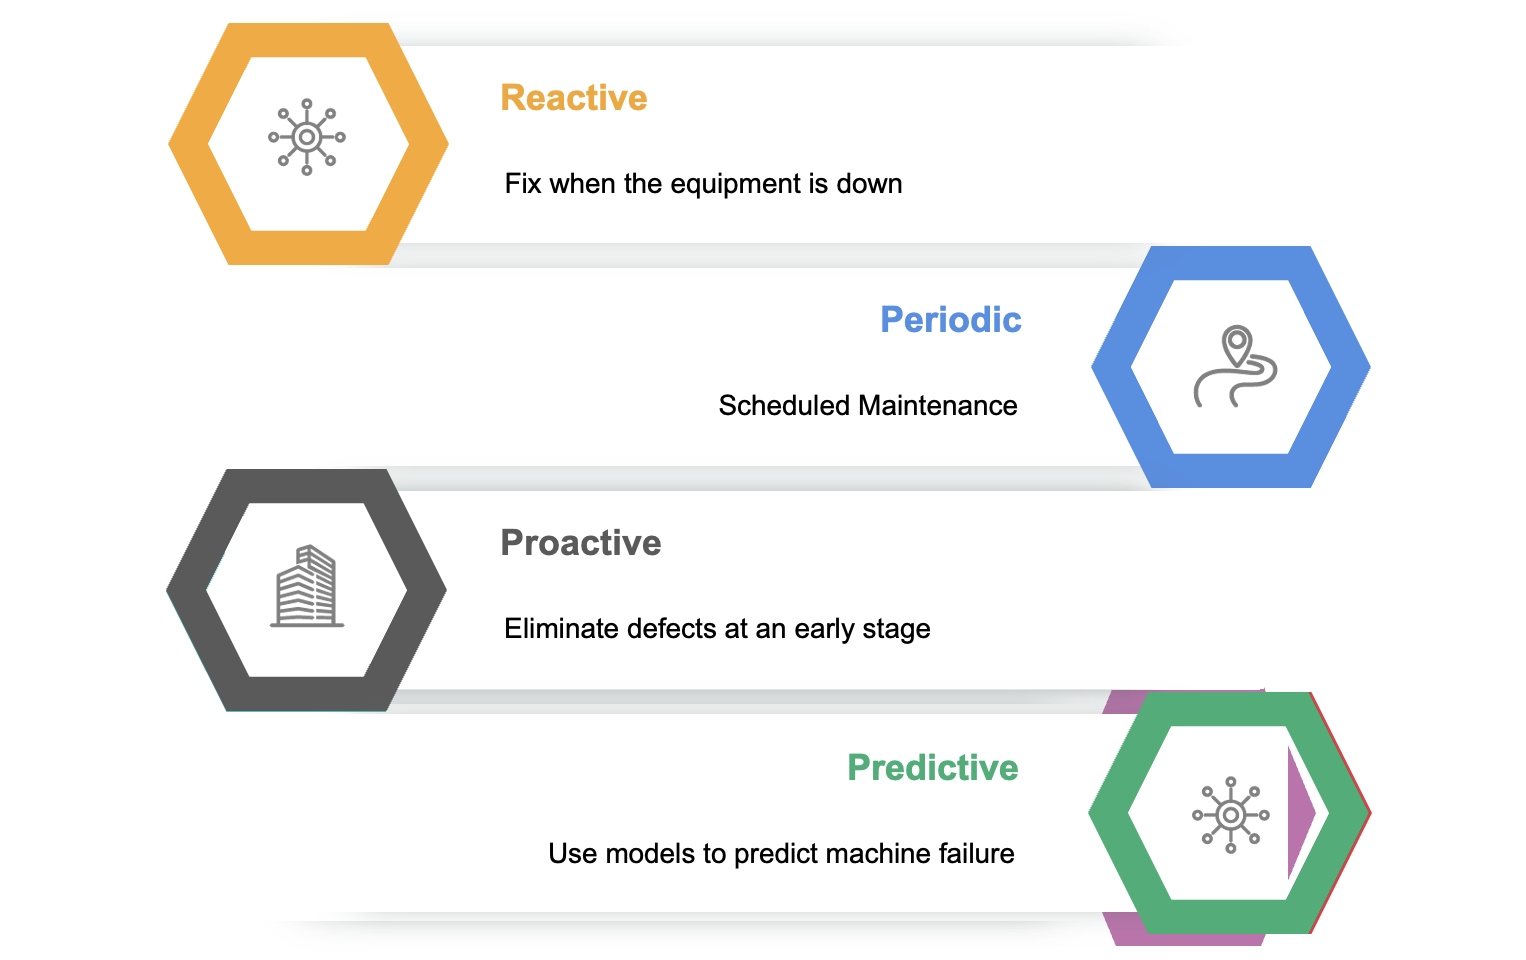

### Import Libraries

In [ ]:
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

In [ ]:
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU

### Load the dataset

Download the dataset from Azure


1.   Training Data
2.   Test Data
3.   Truth label for test data

We download the azure dataset using wget command

In [ ]:
# Data ingestion - reading the datasets from Azure blob 
!wget http://azuremlsamples.azureml.net/templatedata/PM_train.txt
!wget http://azuremlsamples.azureml.net/templatedata/PM_test.txt
!wget http://azuremlsamples.azureml.net/templatedata/PM_truth.txt

--2021-06-27 20:51:17--  http://azuremlsamples.azureml.net/templatedata/PM_train.txt
Resolving azuremlsamples.azureml.net (azuremlsamples.azureml.net)... 13.107.246.40, 13.107.213.40, 2620:1ec:bdf::40, ...
Connecting to azuremlsamples.azureml.net (azuremlsamples.azureml.net)|13.107.246.40|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3515356 (3.4M) [text/plain]
Saving to: ‘PM_train.txt.6’

PM_train.txt.6      100%[===================>]   3.35M  --.-KB/s    in 0.1s    

2021-06-27 20:51:17 (29.8 MB/s) - ‘PM_train.txt.6’ saved [3515356/3515356]

--2021-06-27 20:51:17--  http://azuremlsamples.azureml.net/templatedata/PM_test.txt
Resolving azuremlsamples.azureml.net (azuremlsamples.azureml.net)... 13.107.246.40, 13.107.213.40, 2620:1ec:bdf::40, ...
Connecting to azuremlsamples.azureml.net (azuremlsamples.azureml.net)|13.107.246.40|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2228855 (2.1M) [text/plain]
Saving to: ‘PM_test.txt.6’

PM_te

Load the dataset into dataframe and name the features

[read_csv()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) is used for loading csv files into a pandas dataframe. The seperator is space(" ") as used in the dataset and header=None is used to specify that header is not present.

In [ ]:
# Training data where the last cycle is the failure point for the engines
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)

# Test data where the failure point is not given for the engines
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)

# Printing the first 5 values of train data
train_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


Let's drop the NAN columns 26 and 27 using [dropna()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html) method where axis=1 indicates that NAN columns are to be dropped and inplace=True indicates that the operation will change the original array in place.

In [ ]:
# last two columns are not real
train_df.dropna(axis=1, inplace=True)
test_df.dropna(axis=1, inplace=True)

Let's name columns as per the data definition, given at azure website.

In [ ]:
cols_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df.columns = cols_names
test_df.columns = cols_names

train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


Sorting the dataset by their id and cycles so that each engine will have its values sorted and at one place. We use [sort_values()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html) method and specify which columns are to be considered while sorting in the parameter.

In [ ]:
train_df.sort_values(['id','cycle'], inplace=True)
test_df.sort_values(['id','cycle'], inplace=True)

Loading the ground truth for the test data which indicates the remaining useful cycles for the engines.

In [ ]:
truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)
truth_df.head()

,0,1
0,112,NaN
1,98,NaN
2,69,NaN
3,82,NaN
4,91,NaN


In [ ]:
# dropping the NAN column
truth_df.dropna(axis=1, inplace=True)

### Data Preprocessing

Training set preprocessing


1.   Calculate Remaining Useful Life (cycle)
2.   Label the data for classification
3.   Normalize the dataset



Calculate the Remianing Useful Life

First we find maximum cycles observed for each engine using [groupby()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) and then merge these values for respective engines data using [merge()](https://pandas.pydata.org/docs/reference/api/pandas.merge.html).

Then we calculate Remaining Useful Life (RUL) by substracting the current cycle value from max. Eg - A cycle has total life of 192 cycles and it's already run 50 cycles  currently hence it's RUL will be 192-50 = 142.

In [ ]:
# calculate max cycles for each engine id
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
# name the columns and merge it with the training data
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')

# now substract the current cycle with max cycle to calculate remaining useful life
train_df['RUL'] = train_df['max'] - train_df['cycle']
# drop the irrelevant feature
train_df.drop('max', axis=1, inplace=True)

train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [ ]:
rul.head()

,id,max
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269


Generate label column for training data

Since we are interested in classification problem hence we will label the data according to our problem statement using numpy [where()](https://numpy.org/doc/stable/reference/generated/numpy.where.html) function.

In [ ]:
# we'll make a label which will indicate whether the engine is going to fail within w1 cycles?
w1 = 30
train_df['failure_within_w1'] = np.where(train_df['RUL'] <= w1, 1, 0 )

Normalize the training dataset

For Normalizing, some columns we don't want to consider. We leave these columns using [difference()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Index.difference.html).

Then we normalize the values between 0 and 1 using [MinMaxScaler()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) and then join it with the columns we left out previously using [join()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.join.html). [Reindex()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reindex.html) is used for reindexing the value of the dataset starting from 0.

In [ ]:
# making a separate feature for normalized value of cycle column
train_df['cycle_norm'] = train_df['cycle']

# Using difference function we leave out these column out of normalization
cols_normalize = train_df.columns.difference(['id','cycle','RUL','failure_within_w1'])

# MinMax normalization (from 0 to 1) of sensor data
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL,failure_within_w1,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,1.0,0.726248,0.242424,0.109755,0.0,0.369048,0.633262,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,1.0,0.628019,0.212121,0.100242,0.0,0.380952,0.765458,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,1.0,0.710145,0.272727,0.140043,0.0,0.250000,0.795309,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,1.0,0.740741,0.318182,0.124518,0.0,0.166667,0.889126,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,1.0,0.668277,0.242424,0.149960,0.0,0.255952,0.746269,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0.01108


Test set preprocessing


1.   Normalize the dataset
2.   Label the dataset

Normalize the test set similar to the training data.

In [ ]:
# MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)

Labeling the test set similarly we did for training data.

In [ ]:
# Let's calculate total RUL by summing up the maximum cycles given in test set and ground truth additional RUL
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['additional_rul']

# id can be obtained by adding 1 in index as index starts from 0
truth_df['id'] = truth_df.index + 1

# adding the max cycles given in test set and additional RUL given in ground truth dataframe
truth_df['max'] = rul['max'] + truth_df['additional_rul']
truth_df.drop('additional_rul', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# generate label columns w0 and w1 for test data
test_df['failure_within_w1'] = np.where(test_df['RUL'] <= w1, 1, 0 )

In [ ]:
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,failure_within_w1
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,1.0,0.652174,0.212121,0.127614,0.0,0.208333,0.646055,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,1.0,0.805153,0.166667,0.146684,0.0,0.386905,0.739872,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,1.0,0.685990,0.227273,0.158081,0.0,0.386905,0.699360,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,1.0,0.679549,0.196970,0.105717,0.0,0.255952,0.573561,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,1.0,0.694042,0.166667,0.102396,0.0,0.273810,0.737740,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138,0


### Data Visualisation

Let's see how the sensor values are changing for a particular engine id say id=1

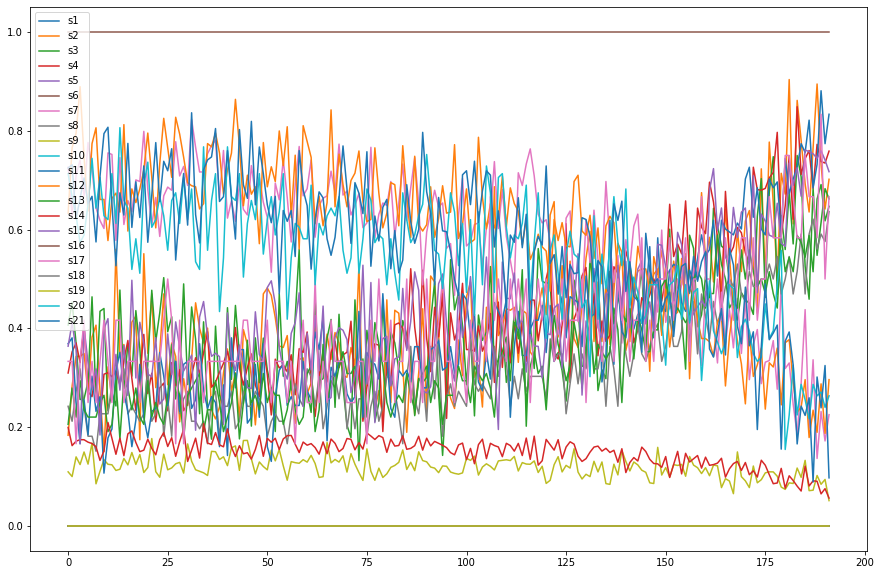

In [ ]:
sensor_cols = cols_names[5:]
train_df[train_df.id==1][sensor_cols].plot(figsize=(15, 10))

You can see that most sensor values are following a trend as number of current cycles increase.

We can see that sensor2 values are increasing whereas sensor7 values are decreasing with increasing cycles.

We can find other such patterns as well, which will assist our model to capture the inherent relationship between the sensor values and the failure point.

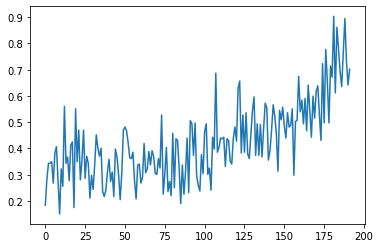

In [ ]:
train_df[train_df.id==1][sensor_cols[1]].plot()

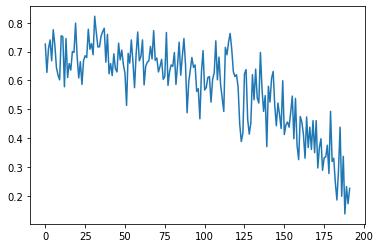

In [ ]:
train_df[train_df.id==1][sensor_cols[6]].plot()

### Model Building

In [ ]:
# sequence length to be used for predictions
sequence_length = 50

In [ ]:
# function to generate sequences of shape (samples, time steps, features) for a particular engine id

def sequence_generator(feature_df, seq_length, seq_cols):
    # we will not be using any sequence which is below seq_length
    # convert the dataframe into numpy 2d array
    feature_array = feature_df[seq_cols].values
    num_elements = feature_array.shape[0]

    # we want to generate sequences of 50 time steps at a time
    # hence iterate over two sets of indices (0,142),(50,192)
    # For example id1 have 192 rows and sequence_length is equal to 50
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 141 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield feature_array[start:stop, :]

In [ ]:
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols) # add the elements of sensor_cols into sequence_cols

In [ ]:
# generate sequnces for each engine id
# unique() returns all the unique ids in a list
seq_gen = (list(sequence_generator(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

# concatenate sequences of different engine ids into one and convert to numpy array [(142, 50, 25), ...] --> [(ntotal, 50, 25)]
seq_set = np.concatenate(list(seq_gen)).astype(np.float32)

# the shape denotes (number of samples, number of time steps, number of features)
seq_set.shape

(15631, 50, 25)

In [ ]:
# function to generate labels
def label_generator(label_df, seq_length, label):
    # Funtion will return
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]]
    # convert the labels to the numpy 2d array 
    label_array = label_df[label].values
    num_elements = label_array.shape[0]
    # Remove the first label since the first prediction will be the (seq_length+1)th label. 
    return label_array[seq_length:num_elements, :]

In [ ]:
# generate labels [[142,1], [121, 1], [3]] --> [1, 2, 3] (ntotal, 1)
label_gen = [label_generator(train_df[train_df['id']==id], sequence_length, ['failure_within_w1']) 
             for id in train_df['id'].unique()]
label_set = np.concatenate(label_gen).astype(np.float32)
label_set.shape

(15631, 1)

Let's build the model using [keras API](https://keras.io/api/models/model_training_apis/)

In [ ]:
# Model - (100 LSTM units with 0.2 dropout) + 
#         (50 LSTM units with 0.2 dropout) + 
#         (dense layer with sigmoid activation)

features_dim = seq_set.shape[2] # number of features
out_dim = label_set.shape[1] # sequence length

print("Features dimension: ", features_dim)
print("Output dimension: ", out_dim)

model = Sequential()

# understanding of return_sequences and connection across LSTM layers
model.add(LSTM(
         input_shape=(sequence_length, features_dim),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=out_dim, activation='sigmoid'))

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# define path to save model
model_path = 'binary_model.h5'

Features dimension:  25
Output dimension:  1
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 50, 100)           50400     
_________________________________________________________________
dropout_14 (Dropout)         (None, 50, 100)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_15 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
_________________________________________________________________
None


Let's fit the model with batch size of 200 and for 200 epochs. we'll save the best model weights using [ModelCheckpoint](https://keras.io/api/callbacks/model_checkpoint/) and also using [EarlyStopping](https://keras.io/api/callbacks/early_stopping/) to prevent overfitting.

In [ ]:
import time
epochs = 200
batch_size = 200
start = time.time()

# fit the network
history = model.fit(seq_set, label_set, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")


Epoch 1/200
75/75 - 4s - loss: 0.2618 - accuracy: 0.8890 - val_loss: 0.1145 - val_accuracy: 0.9514
Epoch 2/200
75/75 - 1s - loss: 0.1022 - accuracy: 0.9590 - val_loss: 0.0642 - val_accuracy: 0.9693
Epoch 3/200
75/75 - 1s - loss: 0.0813 - accuracy: 0.9669 - val_loss: 0.0689 - val_accuracy: 0.9629
Epoch 4/200
75/75 - 1s - loss: 0.0745 - accuracy: 0.9686 - val_loss: 0.0459 - val_accuracy: 0.9795
Epoch 5/200
75/75 - 1s - loss: 0.0727 - accuracy: 0.9695 - val_loss: 0.0413 - val_accuracy: 0.9847
Epoch 6/200
75/75 - 1s - loss: 0.0614 - accuracy: 0.9740 - val_loss: 0.0529 - val_accuracy: 0.9757
Epoch 7/200
75/75 - 1s - loss: 0.0687 - accuracy: 0.9723 - val_loss: 0.0566 - val_accuracy: 0.9770
Epoch 8/200
75/75 - 1s - loss: 0.0559 - accuracy: 0.9771 - val_loss: 0.0395 - val_accuracy: 0.9847
Epoch 9/200
75/75 - 1s - loss: 0.0539 - accuracy: 0.9778 - val_loss: 0.0554 - val_accuracy: 0.9757
Epoch 10/200
75/75 - 1s - loss: 0.0602 - accuracy: 0.9738 - val_loss: 0.0805 - val_accuracy: 0.9552
Epoch 11/

## Model Evaluation on Validation set

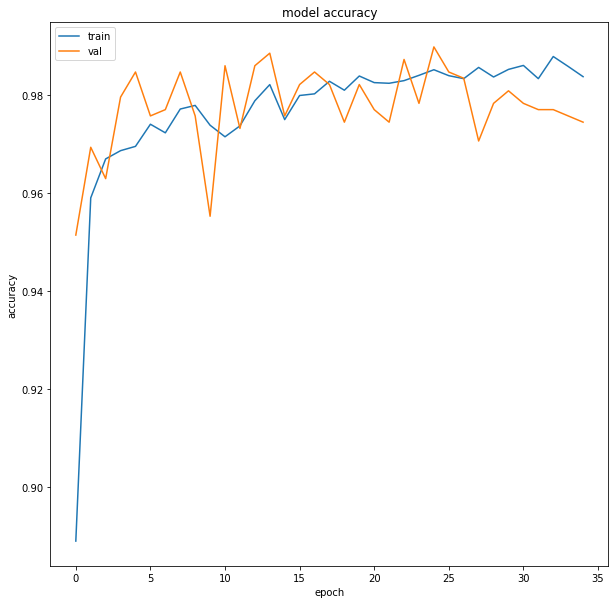

In [ ]:
# Plotting the change in model accuracy on train and val sets
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
fig_acc.savefig("model_accuracy.png")

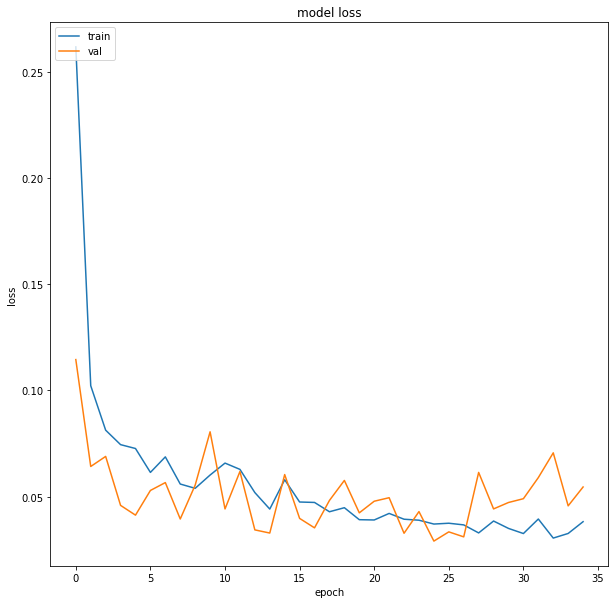

In [ ]:
# Plot model loss for train and test sets
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
fig_acc.savefig("model_loss.png")

In [ ]:
# training metrics
scores = model.evaluate(seq_set, label_set, verbose=1, batch_size=50)
print('Train Accurracy: {}'.format(scores[1]))

# make predictions and compute confusion matrix
y_pred = model.predict_classes(seq_set, verbose=1, batch_size=200)
y_true = label_set

test_set = pd.DataFrame(y_pred)
test_set.to_csv('binary_submit_train.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
print(cm)

# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'Train Precision = ', precision, '\n', 'Train Recall = ', recall)

313/313 [==============================] - 1s 4ms/step - loss: 0.0320 - accuracy: 0.9857
Train Accurracy: 0.9857334494590759


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


79/79 [==============================] - 1s 4ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12520    11]
 [  212  2888]]
Train Precision =  0.9962055881338393 
 Train Recall =  0.9316129032258065


## Model Evaluation on Test set

3/3 - 1s - loss: 0.0519 - accuracy: 0.9785
Total time taken for inferencing:  0.61  secs
Test Accurracy: 0.9784946441650391


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[67  1]
 [ 1 24]]
Test Precision:  0.96 
 Test Recall:  0.96 
 Test F1-score: 0.96


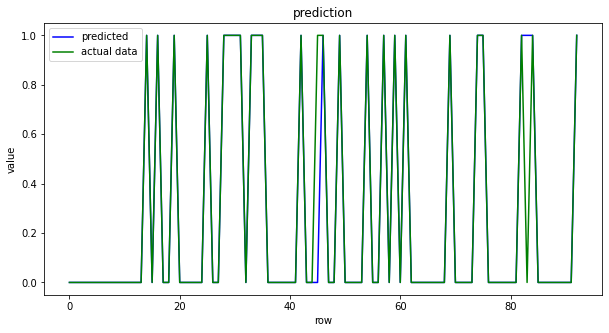

In [ ]:
# considering all the last sequences of test set
last_test_seq = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]
last_test_seq = np.asarray(last_test_seq).astype(np.float32)

# get labels of test set
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
last_test_label = test_df.groupby('id')['failure_within_w1'].nth(-1)[y_mask].values
last_test_label = last_test_label.reshape(last_test_label.shape[0],1).astype(np.float32)

# if best model weights were saved then load it
if os.path.isfile(model_path):
    estimator = load_model(model_path)

# test metrics
start = time.time()
scores_test = estimator.evaluate(last_test_seq, last_test_label, verbose=2)
end = time.time()
print("Total time taken for inferencing: ", "{:.2f}".format((end-start)), " secs")

print('Test Accurracy: {}'.format(scores_test[1]))

# make predictions and compute confusion matrix
y_pred_test = estimator.predict_classes(last_test_seq)
y_true_test = last_test_label

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('binary_submit_test.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
conf_m = confusion_matrix(y_true_test, y_pred_test)
print(conf_m)

# compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Test Precision: ', precision_test, '\n', 'Test Recall: ', recall_test,'\n', 'Test F1-score:', f1_test )

# Plot in blue color the predicted data and in green color the
# actual data to verify visually the accuracy of the model.
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test, color="blue")
plt.plot(y_true_test, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()
fig_verify.savefig("model_verify.png")

In [ ]:
print(features_dim)

25


# References


- [1] Deep Learning for Predictive Maintenance https://github.com/Azure/lstms_for_predictive_maintenance/blob/master/Deep%20Learning%20Basics%20for%20Predictive%20Maintenance.ipynb
- [2] Predictive Maintenance: Step 2A of 3, train and evaluate regression models https://gallery.cortanaintelligence.com/Experiment/Predictive-Maintenance-Step-2A-of-3-train-and-evaluate-regression-models-2
- [3] A. Saxena and K. Goebel (2008). "Turbofan Engine Degradation Simulation Data Set", NASA Ames Prognostics Data Repository (https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan), NASA Ames Research Center, Moffett Field, CA 
- [4] Understanding LSTM Networks http://colah.github.io/posts/2015-08-Understanding-LSTMs/

